In [61]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
#from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np
import csv


# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW

In [62]:
def labeliser_tweet(df, nb_tweets=5, random_state=0):
    
    # Vérifier si le fichier "label.csv" existe et charger les tweet_id déjà labelisés
    tweets_labelises = set()
    try:
        with open('label.csv', mode='r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                tweets_labelises.add(row['tweet_id'])
    except FileNotFoundError:
        pass
    
    # Sélectionner un échantillon aléatoire de tweets non encore labelisés
    df_a_labeliser = df[~df.index.isin(tweets_labelises)].sample(n=nb_tweets, random_state=random_state)
    
    # Labeliser les tweets sélectionnés et enregistrer les labels dans un fichier CSV
    with open('label.csv', mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['tweet_id', 'text', 'label'])
        for tweet_id, text in df_a_labeliser['text'].items():
            label = input(f'Label pour le tweet suivant :\n{text}\n')
            # Écrire les données labelisées dans le fichier CSV
            writer.writerow([tweet_id, text, label])


In [3]:
df = pd.read_csv('data/data_concat_clean/base_annotation_fev23.csv', index_col='tweet_id').drop('Unnamed: 0', axis=1)

In [7]:
labeliser_tweet(df, nb_tweets=100, random_state = 25)

Label pour le tweet suivant :
Homme femelle N°19: 🤳"Fais très vite mon amour, car tu dois ensuite aller lui les torcher... Ta chérie qui t'aime".  #feminisme #metoo #violencesconjugales https://t.co/wEyZ2ucc0c
3
Label pour le tweet suivant :
Procès de #balancetonporc : Sandra Muller dénonce “une inversion des rôles où le prédateur devient la proie, la proie devient le prédateur"  ➡ https://t.co/tXIFSsR12K https://t.co/law5XfRHTz
1
Label pour le tweet suivant :
@canalplus, une réaction officielle peut-être sur les révélations visant @PierreMenes ?... #PierreMenesOut #balancetonporc   #BalanceTonMenes #JeNeSuisPasUneSalope https://t.co/ParThES1UG
2
Label pour le tweet suivant :
“J’ai poussé un cri de colère” : jugée en diffamation, la journaliste Sandra Muller à l’origine de #Balancetonporc plaide “la libération de la parole des femmes” https://t.co/nHix95DBmq
1
Label pour le tweet suivant :
https://t.co/wFK3baer5V … dossier sur anissa jbr (achat de follower ,consomation de stup escortin

In [63]:
df_label = pd.read_csv('label.csv')

In [64]:
df_label = df_label.dropna()

In [65]:
df_label = df_label.drop(1979)


In [66]:
import re
# Filtrer les chaînes de caractères contenant des lettres dans la colonne "label"
has_strings = df_label['label'].apply(lambda x: bool(re.search('[a-zA-Z]', str(x))))

if has_strings.any():
    # Supprimer les lignes contenant des chaînes de caractères avec des lettres dans la colonne "label"
    df_label = df_label[~has_strings]
    print("Les lignes contenant des chaînes de caractères avec des lettres ont été supprimées.")
else:
    print("Il n'y a pas de chaînes de caractères avec des lettres dans la colonne 'label'.")


Il n'y a pas de chaînes de caractères avec des lettres dans la colonne 'label'.


In [67]:
df_label.label = [int(label) for label in df_label.label]


In [68]:
df_label.label.value_counts()

label
2    1331
1     412
3     182
0      81
Name: count, dtype: int64

In [69]:
# Defining constants
epochs = 50
MAX_LEN = 300
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [71]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=4)
model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [72]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=10e-8)

/opt/mamba/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
text = df_label['text'].to_list()
labels = df_label['label'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [74]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.4, stratify = labels)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [75]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
train_loss_set = []
best_validation_loss = float('inf')
epochs_no_improve = 0  # nombre d'epochs consécutives sans amélioration de la validation
best_model = None  # stockage du meilleur modèle
for epoch in trange(epochs, desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Evaluate on validation data
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
            tmp_eval_loss, logits = outputs[:2]
    
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += b_input_ids.size(0)
            nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

    # Check for early stopping
    validation_loss = eval_loss/nb_eval_steps
    if validation_loss < best_validation_loss - 0.01:
        best_validation_loss = validation_loss
        epochs_no_improve = 0

        # Enregistrer le meilleur modèle
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve == 10:
        print("Early stopping! No improvement in validation loss for 10 consecutive epochs.")
        break

# Enregistrer le meilleur modèle sur le disque
if best_model is not None:
    torch.save(best_model, "best_model.pth")


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.9748553665060746


Epoch:   2%|▏         | 1/50 [05:49<4:45:30, 349.60s/it]

Validation Accuracy: 0.6665178571428572
Train loss: 0.8132788131111547


Epoch:   4%|▍         | 2/50 [12:09<4:54:09, 367.69s/it]

Validation Accuracy: 0.7814903846153847
Train loss: 0.636475898717579


Epoch:   6%|▌         | 3/50 [19:07<5:05:42, 390.26s/it]

Validation Accuracy: 0.832760989010989
Train loss: 0.504281925527673


Epoch:   8%|▊         | 4/50 [25:38<4:59:30, 390.66s/it]

Validation Accuracy: 0.8774038461538461
Train loss: 0.39367974118182536


Epoch:  10%|█         | 5/50 [32:15<4:54:46, 393.04s/it]

Validation Accuracy: 0.8393543956043956
Train loss: 0.32853785941475316


Epoch:  12%|█▏        | 6/50 [38:56<4:50:15, 395.81s/it]

Validation Accuracy: 0.860989010989011
Train loss: 0.27336769041262177


Epoch:  14%|█▍        | 7/50 [45:21<4:41:03, 392.18s/it]

Validation Accuracy: 0.8718063186813187
Train loss: 0.23118420023667186


Epoch:  16%|█▌        | 8/50 [51:37<4:30:57, 387.08s/it]

Validation Accuracy: 0.8882211538461539
Train loss: 0.207986234050048


Epoch:  18%|█▊        | 9/50 [58:02<4:23:58, 386.31s/it]

Validation Accuracy: 0.8762019230769231
Train loss: 0.17864405167730232


Epoch:  20%|██        | 10/50 [1:04:24<4:16:40, 385.01s/it]

Validation Accuracy: 0.8573832417582418
Train loss: 0.14990130459007464


Epoch:  22%|██▏       | 11/50 [1:10:39<4:08:20, 382.05s/it]

Validation Accuracy: 0.8657967032967033
Train loss: 0.14182989220870168


Epoch:  24%|██▍       | 12/50 [1:17:14<4:04:27, 385.98s/it]

Validation Accuracy: 0.8918269230769231
Train loss: 0.1237568037682458
Train loss: 0.10782157904223393


Epoch:  28%|██▊       | 14/50 [1:29:59<3:50:10, 383.63s/it]

Validation Accuracy: 0.8657967032967033
Train loss: 0.11725765270622153


Epoch:  30%|███       | 15/50 [1:35:32<3:34:52, 368.35s/it]

Validation Accuracy: 0.8778159340659341
Train loss: 0.11720255762338638


Epoch:  32%|███▏      | 16/50 [1:42:14<3:34:30, 378.54s/it]

Validation Accuracy: 0.817135989010989
Train loss: 0.10115535459236095


Epoch:  32%|███▏      | 16/50 [1:48:49<3:51:15, 408.11s/it]

Validation Accuracy: 0.8740041208791209
Early stopping! No improvement in validation loss for 10 consecutive epochs.


In [82]:
torch.save("best_model.pth", "classif_model.pth")

In [76]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=4)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [77]:
def predict(model, dataloader):
    # mettre le modèle en mode d'évaluation
    model.eval()
    
    # stocker les prédictions de tous les batchs dans une liste
    predictions = []
    
    # boucle sur les batches dans le dataloader de test
    for batch in dataloader:
        
        # déplacer les données sur le même dispositif que le modèle
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # désactiver le calcul des gradients pour économiser de la mémoire et accélérer les calculs
        with torch.no_grad():
            # faire passer les données à travers le modèle pour obtenir les logits
            outputs =  model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
    
        # appliquer la fonction softmax pour obtenir les probabilités pour chaque classe
        probs = F.softmax(logits, dim=-1)
        
        # convertir les probabilités en prédictions en prenant l'indice de la classe avec la probabilité la plus élevée
        batch_preds = torch.argmax(probs, dim=1)
        
        # ajouter les prédictions pour ce batch à la liste de prédictions globale
        predictions.extend(batch_preds.cpu().numpy().tolist())
    
    # retourner la liste de prédictions globale
    return predictions


In [78]:
predictions_val = predict(model, validation_dataloader)


In [ ]:
unique, counts = np.unique(validation_labels.numpy(), return_counts=True)
label_counts = dict(zip(unique, counts))
print(label_counts)

In [79]:
cm = confusion_matrix(validation_labels, predictions_val)

In [80]:
cm_df = pd.DataFrame(cm,
                     index = ['Autre','Presse','Opinion','Témoignage'], 
                     columns = ['Autre','Presse','Opinion','Témoignage'])

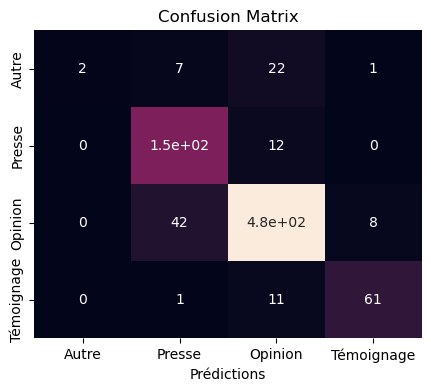

In [81]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cbar = False)
plt.title('Confusion Matrix')
plt.ylabel('')
plt.xlabel('Prédictions')
plt.show()

In [55]:
# Charger les données et les mettre au format approprié
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Inférer les prédictions et les probabilités de chaque classe
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    probs = torch.softmax(logits, dim=-1)
    preds = torch.argmax(logits, dim=-1)


NameError: name 'texts' is not defined

In [ ]:
# Ajouter une colonne de prédictions
df["predictions"] = preds.cpu().numpy()

# Ajouter des colonnes de probabilités pour chaque classe
for i, label in enumerate(label_list):
    df[label] = probs[:, i].cpu().numpy()


In [12]:
### sans early stopping
train_loss_set=[]
for _ in trange(epochs, desc="Epoch"):  
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs =  model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
            loss, logits = outputs[:2]
    
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.2618875404198964


Epoch:  10%|█         | 1/10 [11:58<1:47:46, 718.47s/it]

Validation Accuracy: 0.683666087962963
Train loss: 1.0668712556362152


Epoch:  20%|██        | 2/10 [26:31<1:47:53, 809.18s/it]

Validation Accuracy: 0.683666087962963
Train loss: 0.957703024148941


Epoch:  30%|███       | 3/10 [41:12<1:38:15, 842.14s/it]

Validation Accuracy: 0.683666087962963
Train loss: 0.8441829631725947


Epoch:  40%|████      | 4/10 [56:13<1:26:33, 865.51s/it]

Validation Accuracy: 0.7936197916666666
Train loss: 0.7229040463765463


Epoch:  50%|█████     | 5/10 [1:11:12<1:13:06, 877.36s/it]

Validation Accuracy: 0.7316261574074074
Train loss: 0.6163275490204493


Epoch:  60%|██████    | 6/10 [1:25:21<57:51, 867.90s/it]  

Validation Accuracy: 0.7779947916666666
Train loss: 0.5189388146003088


Epoch:  70%|███████   | 7/10 [1:38:30<42:06, 842.19s/it]

Validation Accuracy: 0.8236400462962963
Train loss: 0.4161665042241414


Epoch:  80%|████████  | 8/10 [1:46:59<24:32, 736.00s/it]

Validation Accuracy: 0.8298611111111112
Train loss: 0.3496982256571452


Epoch:  90%|█████████ | 9/10 [1:54:01<10:37, 637.84s/it]

Validation Accuracy: 0.8383969907407407
Train loss: 0.2971478613714377


Epoch: 100%|██████████| 10/10 [2:00:39<00:00, 723.93s/it]

Validation Accuracy: 0.8423032407407407
